# Fit logistic regression model

- based on different imputation methods
- baseline: reference
- model: any other selected imputation method

In [1]:
import logging
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import njab.sklearn
import pandas as pd
import sklearn
from njab.plotting.metrics import plot_split_auc, plot_split_prc
from njab.sklearn.types import Splits

import vaep
import vaep.analyzers
import vaep.io.datasplits

plt.rcParams['figure.figsize'] = (2.5, 2.5)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 2
fontsize = 5
figsize = (2.5, 2.5)
vaep.plotting.make_large_descriptors(fontsize)


logger = vaep.logging.setup_nb_logger()
logging.getLogger('fontTools').setLevel(logging.ERROR)


def parse_roc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _roc = (pd.DataFrame(_r.test.roc,
                             index='fpr tpr cutoffs'.split()
                             )).loc[['fpr', 'tpr']]
        _roc = _roc.T
        _roc.columns = pd.MultiIndex.from_product([[_r.name], _roc.columns])
        ret.append(_roc)
    ret = pd.concat(ret, axis=1)
    return ret


def parse_prc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _prc = pd.DataFrame(_r.test.prc,
                            index='precision recall cutoffs'.split()
                            ).loc[['precision', 'recall']]
        _prc = _prc.T.rename(columns={'recall': 'tpr'})
        _prc.columns = pd.MultiIndex.from_product([[_r.name], _prc.columns])
        ret.append(_prc)
    ret = pd.concat(ret, axis=1)
    return ret


# catch passed parameters
args = None
args = dict(globals()).keys()

## Parameters
Default and set parameters for the notebook.

In [2]:
folder_data: str = ''  # specify data directory if needed
fn_clinical_data = "data/ALD_study/processed/ald_metadata_cli.csv"
folder_experiment = "runs/appl_ald_data/plasma/proteinGroups"
model_key = 'VAE'
target = 'kleiner'
sample_id_col = 'Sample ID'
cutoff_target: int = 2  # => for binarization target >= cutoff_target
file_format = "csv"
out_folder = 'diff_analysis'
fn_qc_samples = ''  # 'data/ALD_study/processed/qc_plasma_proteinGroups.pkl'

baseline = 'RSN'  # default is RSN, as this was used in the original ALD Niu. et. al 2022
template_pred = 'pred_real_na_{}.csv'  # fixed, do not change

In [3]:
# Parameters
cutoff_target = 0.5
folder_experiment = "runs/alzheimer_study"
target = "AD"
baseline = "PI"
model_key = "DAE"
out_folder = "diff_analysis"
fn_clinical_data = "runs/alzheimer_study/data/clinical_data.csv"


In [4]:
params = vaep.nb.get_params(args, globals=globals())
args = vaep.nb.Config()
args.folder_experiment = Path(params["folder_experiment"])
args = vaep.nb.add_default_paths(args,
                                 out_root=(args.folder_experiment
                                           / params["out_folder"]
                                           / params["target"]
                                           / f"{params['baseline']}_vs_{params['model_key']}"))
args.update_from_dict(params)
files_out = dict()
args

root - INFO     Removed from global namespace: folder_data


root - INFO     Removed from global namespace: fn_clinical_data


root - INFO     Removed from global namespace: folder_experiment


root - INFO     Removed from global namespace: model_key


root - INFO     Removed from global namespace: target


root - INFO     Removed from global namespace: sample_id_col


root - INFO     Removed from global namespace: cutoff_target


root - INFO     Removed from global namespace: file_format


root - INFO     Removed from global namespace: out_folder


root - INFO     Removed from global namespace: fn_qc_samples


root - INFO     Removed from global namespace: baseline


root - INFO     Removed from global namespace: template_pred


root - INFO     Already set attribute: folder_experiment has value runs/alzheimer_study


root - INFO     Already set attribute: out_folder has value diff_analysis


{'baseline': 'PI',
 'cutoff_target': 0.5,
 'data': PosixPath('runs/alzheimer_study/data'),
 'file_format': 'csv',
 'fn_clinical_data': 'runs/alzheimer_study/data/clinical_data.csv',
 'fn_qc_samples': '',
 'folder_data': '',
 'folder_experiment': PosixPath('runs/alzheimer_study'),
 'model_key': 'DAE',
 'out_figures': PosixPath('runs/alzheimer_study/figures'),
 'out_folder': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE'),
 'out_metrics': PosixPath('runs/alzheimer_study'),
 'out_models': PosixPath('runs/alzheimer_study'),
 'out_preds': PosixPath('runs/alzheimer_study/preds'),
 'sample_id_col': 'Sample ID',
 'target': 'AD',
 'template_pred': 'pred_real_na_{}.csv'}

## Load data

### Load target

In [5]:
target = pd.read_csv(args.fn_clinical_data,
                     index_col=0,
                     usecols=[args.sample_id_col, args.target])
target = target.dropna()
target

,AD
Sample ID,
Sample_000,0
Sample_001,1
Sample_002,1
Sample_003,1
Sample_004,1
...,...
Sample_205,1
Sample_206,0
Sample_207,0


### MS proteomics or specified omics data
Aggregated from data splits of the imputation workflow run before.

In [6]:
data = vaep.io.datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)
data = pd.concat([data.train_X, data.val_y, data.test_y])
data.sample(5)

vaep.io.datasplits - INFO     Loaded 'train_X' from file: runs/alzheimer_study/data/train_X.csv


vaep.io.datasplits - INFO     Loaded 'val_y' from file: runs/alzheimer_study/data/val_y.csv


vaep.io.datasplits - INFO     Loaded 'test_y' from file: runs/alzheimer_study/data/test_y.csv


Sample ID   protein groups   
Sample_051  P30048;P30048-2     14.340
Sample_015  A0A1X7SBT7;O95502   19.207
Sample_010  P26447              14.789
Sample_118  P11717              15.021
Sample_208  P04406              18.041
Name: intensity, dtype: float64

Get overlap between independent features and target

### Select by ALD criteria
Use parameters as specified in [ALD study](https://github.com/RasmussenLab/pimms/tree/main/project/data/ALD_study).

In [7]:
DATA_COMPLETENESS = 0.6
MIN_N_PROTEIN_GROUPS: int = 200
FRAC_PROTEIN_GROUPS: int = 0.622
CV_QC_SAMPLE: float = 0.4

ald_study, cutoffs = vaep.analyzers.diff_analysis.select_raw_data(data.unstack(
), data_completeness=DATA_COMPLETENESS, frac_protein_groups=FRAC_PROTEIN_GROUPS)

if args.fn_qc_samples:
    qc_samples = pd.read_pickle(args.fn_qc_samples)
    qc_samples = qc_samples[ald_study.columns]
    qc_cv_feat = qc_samples.std() / qc_samples.mean()
    qc_cv_feat = qc_cv_feat.rename(qc_samples.columns.name)
    fig, ax = plt.subplots(figsize=(4, 7))
    ax = qc_cv_feat.plot.box(ax=ax)
    ax.set_ylabel('Coefficient of Variation')
    print((qc_cv_feat < CV_QC_SAMPLE).value_counts())
    ald_study = ald_study[vaep.analyzers.diff_analysis.select_feat(qc_samples)]

column_name_first_prot_to_pg = {
    pg.split(';')[0]: pg for pg in data.unstack().columns}

ald_study = ald_study.rename(columns=column_name_first_prot_to_pg)
ald_study

root - INFO     Initally: N samples: 210, M feat: 1421


root - INFO     Dropped features quantified in less than 126 samples.


root - INFO     After feat selection: N samples: 210, M feat: 1213


root - INFO     Min No. of Protein-Groups in single sample: 754


root - INFO     Finally: N samples: 210, M feat: 1213


protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,NaN,...,16.012,15.178,NaN,15.050,16.842,19.863,NaN,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,NaN,19.067,16.188,...,15.528,15.576,NaN,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,NaN,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,NaN,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,NaN,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,NaN,15.345,17.084,18.708,14.249,19.433,NaN,NaN
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Number of complete cases which can be used:

In [8]:
mask_has_target = data.index.levels[0].intersection(target.index)
assert not mask_has_target.empty, f"No data for target: {data.index.levels[0]} and {target.index}"
print(
    f"Samples available both in proteomics data and for target: {len(mask_has_target)}")
target, data, ald_study = target.loc[mask_has_target], data.loc[mask_has_target], ald_study.loc[mask_has_target]

Samples available both in proteomics data and for target: 210


### Load imputations from specified model

In [9]:
fname = args.out_preds / args.template_pred.format(args.model_key)
print(f"missing values pred. by {args.model_key}: {fname}")
load_single_csv_pred_file = vaep.analyzers.compare_predictions.load_single_csv_pred_file
pred_real_na = load_single_csv_pred_file(fname).loc[mask_has_target]
pred_real_na.sample(3)

missing values pred. by DAE: runs/alzheimer_study/preds/pred_real_na_DAE.csv


Sample ID   protein groups
Sample_200  P13645           18.080
Sample_082  I3L3J8;P14415    16.382
Sample_163  A0A075B7B8       14.832
Name: intensity, dtype: float64

### Load imputations from baseline model

In [10]:
fname = args.out_preds / args.template_pred.format(args.baseline)
pred_real_na_baseline = load_single_csv_pred_file(fname)  # .loc[mask_has_target]
pred_real_na_baseline

Sample ID   protein groups          
Sample_000  A0A075B6J9                 12.209
            A0A075B6Q5                 13.044
            A0A075B6R2                 12.309
            A0A075B6S5                 13.356
            A0A087WSY4                 13.080
                                        ...  
Sample_209  Q9P1W8;Q9P1W8-2;Q9P1W8-4   12.703
            Q9UI40;Q9UI40-2            12.282
            Q9UIW2                     12.088
            Q9UMX0;Q9UMX0-2;Q9UMX0-4   13.875
            Q9UP79                     12.838
Name: intensity, Length: 46401, dtype: float64

## Modeling setup
General approach:
  - use one train, test split of the data
  - select best 10 features from training data `X_train`, `y_train` before binarization of target
  - dichotomize (binarize) data into to groups (zero and 1)
  - evaluate model on the test data `X_test`, `y_test`

Repeat general approach for
 1. all original ald data: all features justed in original ALD study
 2. all model data: all features available my using the self supervised deep learning model
 3. newly available feat only: the subset of features available from the
    self supervised deep learning model which were newly retained using the
    new approach

All data:

In [11]:
X = pd.concat([data, pred_real_na]).unstack()
X

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,17.301,20.246,16.764,17.584,16.988,20.054,...,16.012,15.178,14.056,15.050,16.842,19.863,16.062,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,13.796,19.941,18.786,17.144,16.608,19.067,...,15.528,15.576,14.010,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,18.175,19.251,16.832,15.671,17.012,18.569,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,15.963,19.628,17.852,18.877,14.182,18.985,...,15.495,14.590,14.682,15.140,17.356,19.429,16.013,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,15.473,20.450,18.682,17.081,14.140,19.686,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,15.262,17.705,17.039,15.492,16.413,19.102,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,14.596,18.154,18.152,16.503,16.860,18.538,...,15.422,16.106,14.404,15.345,17.084,18.708,14.249,19.433,11.142,10.723
Sample_207,15.739,16.877,15.469,16.898,13.606,18.636,17.950,16.321,16.401,18.849,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


### Subset of data by ALD criteria

In [12]:
# could be just observed, drop columns with missing values
ald_study = pd.concat(
    [ald_study.stack(),
     pred_real_na_baseline.loc[
        # only select columns in selected in ald_study
        pd.IndexSlice[:, pred_real_na.index.levels[-1].intersection(ald_study.columns)]
    ]
    ]
).unstack()
ald_study

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,12.209,...,16.012,15.178,12.187,15.050,16.842,19.863,13.447,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,13.369,19.067,16.188,...,15.528,15.576,12.729,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,13.648,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,13.834,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,13.682,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,12.498,15.345,17.084,18.708,14.249,19.433,11.124,13.314
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Features which would not have been included using ALD criteria:

In [13]:
new_features = X.columns.difference(ald_study.columns)
new_features

Index(['A0A075B6H7', 'A0A075B6Q5', 'A0A075B7B8', 'A0A087WSY4',
       'A0A087WTT8;A0A0A0MQX5;O94779;O94779-2', 'A0A087WXB8;Q9Y274',
       'A0A087WXE9;E9PQ70;Q6UXH9;Q6UXH9-2;Q6UXH9-3',
       'A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;Q9BUP0-2',
       'A0A0A0MQS9;A0A0A0MTC7;Q16363;Q16363-2', 'A0A0A0MSN4;P12821;P12821-2',
       ...
       'Q9NZ94;Q9NZ94-2;Q9NZ94-3', 'Q9NZU1', 'Q9P1W8;Q9P1W8-2;Q9P1W8-4',
       'Q9UHI8', 'Q9UI40;Q9UI40-2',
       'Q9UIB8;Q9UIB8-2;Q9UIB8-3;Q9UIB8-4;Q9UIB8-5;Q9UIB8-6',
       'Q9UKZ4;Q9UKZ4-2', 'Q9UMX0;Q9UMX0-2;Q9UMX0-4', 'Q9Y281;Q9Y281-3',
       'Q9Y490'],
      dtype='object', name='protein groups', length=208)

Binarize targets, but also keep groups for stratification

In [14]:
target_to_group = target.copy()
target = target >= args.cutoff_target
pd.crosstab(target.squeeze(), target_to_group.squeeze())

AD,0,1
AD,,
False,122,0
True,0,88


## Determine best number of parameters by cross validation procedure

using subset of data by ALD criteria:

In [15]:
cv_feat_ald = njab.sklearn.find_n_best_features(X=ald_study, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_ald = (cv_feat_ald
               .drop('test_case', axis=1)
               .groupby('n_features')
               .agg(['mean', 'std']))
cv_feat_ald

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 370.06it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  4.07it/s]

100%|██████████| 2/2 [00:00<00:00,  4.06it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  5.58it/s]

100%|██████████| 3/3 [00:00<00:00,  3.65it/s]

100%|██████████| 3/3 [00:00<00:00,  3.91it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  4.74it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  3.80it/s]

100%|██████████| 4/4 [00:01<00:00,  3.35it/s]

100%|██████████| 4/4 [00:01<00:00,  3.58it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  3.13it/s]

 60%|██████    | 3/5 [00:01<00:00,  2.35it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.05it/s]

100%|██████████| 5/5 [00:02<00:00,  2.15it/s]

100%|██████████| 5/5 [00:02<00:00,  2.23it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:01,  3.30it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.46it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.52it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  2.58it/s]

100%|██████████| 6/6 [00:02<00:00,  2.68it/s]

100%|██████████| 6/6 [00:02<00:00,  2.66it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:01,  3.68it/s]

 43%|████▎     | 3/7 [00:01<00:01,  2.84it/s]

 57%|█████▋    | 4/7 [00:01<00:01,  2.94it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  2.72it/s]

 86%|████████▌ | 6/7 [00:02<00:00,  2.78it/s]

100%|██████████| 7/7 [00:02<00:00,  2.88it/s]

100%|██████████| 7/7 [00:02<00:00,  2.90it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:01,  3.43it/s]

 38%|███▊      | 3/8 [00:01<00:01,  2.89it/s]

 50%|█████     | 4/8 [00:01<00:01,  2.77it/s]

 62%|██████▎   | 5/8 [00:01<00:01,  2.62it/s]

 75%|███████▌  | 6/8 [00:02<00:00,  2.65it/s]

 88%|████████▊ | 7/8 [00:02<00:00,  2.32it/s]

100%|██████████| 8/8 [00:03<00:00,  2.10it/s]

100%|██████████| 8/8 [00:03<00:00,  2.42it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  3.69it/s]

 33%|███▎      | 3/9 [00:00<00:01,  3.02it/s]

 44%|████▍     | 4/9 [00:01<00:01,  2.81it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  2.37it/s]

 67%|██████▋   | 6/9 [00:02<00:01,  2.13it/s]

 78%|███████▊  | 7/9 [00:03<00:01,  1.93it/s]

 89%|████████▉ | 8/9 [00:03<00:00,  2.03it/s]

100%|██████████| 9/9 [00:03<00:00,  2.19it/s]

100%|██████████| 9/9 [00:03<00:00,  2.31it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:02,  3.16it/s]

 30%|███       | 3/10 [00:01<00:03,  1.98it/s]

 40%|████      | 4/10 [00:02<00:03,  1.77it/s]

 50%|█████     | 5/10 [00:02<00:02,  2.00it/s]

 60%|██████    | 6/10 [00:02<00:01,  2.13it/s]

 70%|███████   | 7/10 [00:03<00:01,  2.20it/s]

 80%|████████  | 8/10 [00:03<00:00,  2.26it/s]

 90%|█████████ | 9/10 [00:04<00:00,  2.34it/s]

100%|██████████| 10/10 [00:04<00:00,  2.32it/s]

100%|██████████| 10/10 [00:04<00:00,  2.21it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:02,  3.66it/s]

 27%|██▋       | 3/11 [00:01<00:03,  2.59it/s]

 36%|███▋      | 4/11 [00:01<00:02,  2.40it/s]

 45%|████▌     | 5/11 [00:02<00:02,  2.30it/s]

 55%|█████▍    | 6/11 [00:02<00:02,  2.36it/s]

 64%|██████▎   | 7/11 [00:02<00:01,  2.48it/s]

 73%|███████▎  | 8/11 [00:03<00:01,  2.57it/s]

 82%|████████▏ | 9/11 [00:03<00:00,  2.69it/s]

 91%|█████████ | 10/11 [00:03<00:00,  2.71it/s]

100%|██████████| 11/11 [00:04<00:00,  2.68it/s]

100%|██████████| 11/11 [00:04<00:00,  2.60it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:02,  3.60it/s]

 25%|██▌       | 3/12 [00:00<00:02,  3.21it/s]

 33%|███▎      | 4/12 [00:01<00:02,  3.01it/s]

 42%|████▏     | 5/12 [00:01<00:02,  2.84it/s]

 50%|█████     | 6/12 [00:01<00:02,  2.90it/s]

 58%|█████▊    | 7/12 [00:02<00:01,  2.89it/s]

 67%|██████▋   | 8/12 [00:02<00:01,  2.86it/s]

 75%|███████▌  | 9/12 [00:03<00:01,  2.93it/s]

 83%|████████▎ | 10/12 [00:03<00:00,  2.93it/s]

 92%|█████████▏| 11/12 [00:03<00:00,  2.94it/s]

100%|██████████| 12/12 [00:04<00:00,  3.02it/s]

100%|██████████| 12/12 [00:04<00:00,  2.98it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:03,  3.57it/s]

 23%|██▎       | 3/13 [00:00<00:03,  2.98it/s]

 31%|███       | 4/13 [00:01<00:03,  2.75it/s]

 38%|███▊      | 5/13 [00:01<00:03,  2.45it/s]

 46%|████▌     | 6/13 [00:02<00:02,  2.43it/s]

 54%|█████▍    | 7/13 [00:02<00:02,  2.53it/s]

 62%|██████▏   | 8/13 [00:02<00:01,  2.65it/s]

 69%|██████▉   | 9/13 [00:03<00:01,  2.67it/s]

 77%|███████▋  | 10/13 [00:03<00:01,  2.78it/s]

 85%|████████▍ | 11/13 [00:04<00:00,  2.82it/s]

 92%|█████████▏| 12/13 [00:04<00:00,  2.64it/s]

100%|██████████| 13/13 [00:04<00:00,  2.40it/s]

100%|██████████| 13/13 [00:04<00:00,  2.61it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:02,  4.95it/s]

 21%|██▏       | 3/14 [00:00<00:03,  3.41it/s]

 29%|██▊       | 4/14 [00:01<00:03,  3.02it/s]

 36%|███▌      | 5/14 [00:01<00:03,  2.74it/s]

 43%|████▎     | 6/14 [00:02<00:03,  2.66it/s]

 50%|█████     | 7/14 [00:02<00:02,  2.74it/s]

 57%|█████▋    | 8/14 [00:02<00:02,  2.64it/s]

 64%|██████▍   | 9/14 [00:03<00:02,  2.34it/s]

 71%|███████▏  | 10/14 [00:03<00:01,  2.19it/s]

 79%|███████▊  | 11/14 [00:04<00:01,  2.15it/s]

 86%|████████▌ | 12/14 [00:04<00:00,  2.10it/s]

 93%|█████████▎| 13/14 [00:05<00:00,  2.18it/s]

100%|██████████| 14/14 [00:05<00:00,  2.23it/s]

100%|██████████| 14/14 [00:05<00:00,  2.46it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  5.38it/s]

 20%|██        | 3/15 [00:00<00:03,  3.32it/s]

 27%|██▋       | 4/15 [00:01<00:03,  2.88it/s]

 33%|███▎      | 5/15 [00:01<00:03,  2.96it/s]

 40%|████      | 6/15 [00:01<00:03,  2.84it/s]

 47%|████▋     | 7/15 [00:02<00:03,  2.30it/s]

 53%|█████▎    | 8/15 [00:03<00:03,  1.98it/s]

 60%|██████    | 9/15 [00:03<00:03,  1.91it/s]

 67%|██████▋   | 10/15 [00:04<00:02,  2.02it/s]

 73%|███████▎  | 11/15 [00:04<00:01,  2.17it/s]

 80%|████████  | 12/15 [00:04<00:01,  2.39it/s]

 87%|████████▋ | 13/15 [00:05<00:00,  2.38it/s]

 93%|█████████▎| 14/15 [00:05<00:00,  2.43it/s]

100%|██████████| 15/15 [00:06<00:00,  2.44it/s]

100%|██████████| 15/15 [00:06<00:00,  2.44it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.004 0.004      0.054 0.025          0.484 0.455       0.061   
2             0.004 0.003      0.057 0.021          0.756 0.082       0.688   
3             0.004 0.002      0.053 0.019          0.779 0.092       0.718   
4             0.006 0.005      0.063 0.032          0.772 0.092       0.725   
5             0.005 0.004      0.061 0.025          0.769 0.098       0.744   
6             0.006 0.005      0.078 0.035          0.758 0.100       0.731   
7             0.007 0.005      0.078 0.025          0.759 0.086       0.759   
8             0.006 0.006      0.076 0.029          0.818 0.070       0.829   
9             0.006 0.004      0.063 0.022          0.817 0.072       0.826   
10            0.006 0.005      0.074 0.030          0.818 0.073       0.830   
11            0.008 0.007      0.081 0.035          0.818 0.074       0.829   
12            0.008 0.006      0.077 0.030          0.807 0.076       0.820   
13            0.007 0.005      0.090 0.032          0.808 0.078       0.815   
14            0.006 0.005      0.080 0.032          0.811 0.082       0.805   
15            0.006 0.004      0.066 0.027          0.802 0.080       0.805   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.071   0.105 0.113                  0.524 0.033        0.849   
2          0.097   0.715 0.064                  0.760 0.050        0.837   
3          0.096   0.742 0.070                  0.781 0.057        0.860   
4          0.116   0.740 0.076                  0.781 0.059        0.871   
5          0.104   0.751 0.077                  0.788 0.063        0.871   
6          0.113   0.738 0.083                  0.778 0.065        0.868   
7          0.082   0.755 0.060                  0.789 0.051        0.890   
8          0.089   0.820 0.060                  0.846 0.052        0.918   
9          0.089   0.818 0.059                  0.844 0.051        0.917   
10         0.091   0.820 0.062                  0.846 0.054        0.915   
11         0.095   0.820 0.068                  0.846 0.059        0.915   
12         0.098   0.810 0.069                  0.837 0.059        0.913   
13         0.096   0.808 0.069                  0.836 0.060        0.912   
14         0.097   0.804 0.067                  0.832 0.057        0.910   
15         0.089   0.800 0.064                  0.828 0.054        0.909   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.065                  0.820 0.088        210.000 0.000  
2          0.057                  0.785 0.084        210.000 0.000  
3          0.060                  0.830 0.083        210.000 0.000  
4          0.055                  0.837 0.073        210.000 0.000  
5          0.054                  0.839 0.071        210.000 0.000  
6          0.053                  0.836 0.070        210.000 0.000  
7          0.049                  0.878 0.053        210.000 0.000  
8          0.045                  0.908 0.046        210.000 0.000  
9          0.045                  0.907 0.046        210.000 0.000  
10         0.047                  0.905 0.048        210.000 0.000  
11         0.047                  0.904 0.049        210.000 0.000  
12         0.047                  0.902 0.049        210.000 0.000  
13         0.046                  0.901 0.048        210.000 0.000  
14         0.048                  0.901 0.049        210.000 0.000  
15         0.047                  0.900 0.048 

Using all data:

In [16]:
cv_feat_all = njab.sklearn.find_n_best_features(X=X, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_all = cv_feat_all.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_all

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 448.54it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  3.39it/s]

100%|██████████| 2/2 [00:00<00:00,  3.33it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  3.10it/s]

100%|██████████| 3/3 [00:01<00:00,  2.26it/s]

100%|██████████| 3/3 [00:01<00:00,  2.38it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  4.43it/s]

 75%|███████▌  | 3/4 [00:01<00:00,  2.60it/s]

100%|██████████| 4/4 [00:01<00:00,  2.38it/s]

100%|██████████| 4/4 [00:01<00:00,  2.60it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  4.51it/s]

 60%|██████    | 3/5 [00:00<00:00,  3.63it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.77it/s]

100%|██████████| 5/5 [00:01<00:00,  2.31it/s]

100%|██████████| 5/5 [00:01<00:00,  2.65it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  5.37it/s]

 50%|█████     | 3/6 [00:00<00:00,  3.96it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  3.46it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  2.63it/s]

100%|██████████| 6/6 [00:02<00:00,  2.01it/s]

100%|██████████| 6/6 [00:02<00:00,  2.53it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:01,  3.29it/s]

 43%|████▎     | 3/7 [00:01<00:01,  2.63it/s]

 57%|█████▋    | 4/7 [00:01<00:01,  2.07it/s]

 71%|███████▏  | 5/7 [00:02<00:01,  1.77it/s]

 86%|████████▌ | 6/7 [00:03<00:00,  1.72it/s]

100%|██████████| 7/7 [00:03<00:00,  1.75it/s]

100%|██████████| 7/7 [00:03<00:00,  1.92it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:01,  3.09it/s]

 38%|███▊      | 3/8 [00:01<00:02,  2.12it/s]

 50%|█████     | 4/8 [00:02<00:02,  1.70it/s]

 62%|██████▎   | 5/8 [00:02<00:01,  1.59it/s]

 75%|███████▌  | 6/8 [00:03<00:01,  1.68it/s]

 88%|████████▊ | 7/8 [00:03<00:00,  1.76it/s]

100%|██████████| 8/8 [00:04<00:00,  1.92it/s]

100%|██████████| 8/8 [00:04<00:00,  1.87it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  4.35it/s]

 33%|███▎      | 3/9 [00:01<00:02,  2.55it/s]

 44%|████▍     | 4/9 [00:01<00:02,  2.13it/s]

 56%|█████▌    | 5/9 [00:02<00:02,  1.93it/s]

 67%|██████▋   | 6/9 [00:02<00:01,  1.96it/s]

 78%|███████▊  | 7/9 [00:03<00:00,  2.14it/s]

 89%|████████▉ | 8/9 [00:03<00:00,  2.14it/s]

100%|██████████| 9/9 [00:04<00:00,  2.15it/s]

100%|██████████| 9/9 [00:04<00:00,  2.20it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  4.33it/s]

 30%|███       | 3/10 [00:00<00:02,  3.29it/s]

 40%|████      | 4/10 [00:01<00:02,  2.47it/s]

 50%|█████     | 5/10 [00:02<00:02,  2.14it/s]

 60%|██████    | 6/10 [00:02<00:01,  2.01it/s]

 70%|███████   | 7/10 [00:03<00:01,  2.11it/s]

 80%|████████  | 8/10 [00:03<00:00,  2.14it/s]

 90%|█████████ | 9/10 [00:03<00:00,  2.21it/s]

100%|██████████| 10/10 [00:04<00:00,  2.27it/s]

100%|██████████| 10/10 [00:04<00:00,  2.33it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  5.90it/s]

 27%|██▋       | 3/11 [00:00<00:02,  3.50it/s]

 36%|███▋      | 4/11 [00:01<00:02,  2.62it/s]

 45%|████▌     | 5/11 [00:02<00:02,  2.04it/s]

 55%|█████▍    | 6/11 [00:02<00:02,  1.84it/s]

 64%|██████▎   | 7/11 [00:03<00:02,  1.78it/s]

 73%|███████▎  | 8/11 [00:03<00:01,  1.91it/s]

 82%|████████▏ | 9/11 [00:04<00:00,  2.10it/s]

 91%|█████████ | 10/11 [00:04<00:00,  1.96it/s]

100%|██████████| 11/11 [00:05<00:00,  1.87it/s]

100%|██████████| 11/11 [00:05<00:00,  2.09it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:02,  4.46it/s]

 25%|██▌       | 3/12 [00:00<00:02,  3.49it/s]

 33%|███▎      | 4/12 [00:01<00:02,  2.88it/s]

 42%|████▏     | 5/12 [00:01<00:02,  2.50it/s]

 50%|█████     | 6/12 [00:02<00:02,  2.10it/s]

 58%|█████▊    | 7/12 [00:03<00:02,  1.93it/s]

 67%|██████▋   | 8/12 [00:03<00:02,  1.65it/s]

 75%|███████▌  | 9/12 [00:04<00:01,  1.64it/s]

 83%|████████▎ | 10/12 [00:05<00:01,  1.60it/s]

 92%|█████████▏| 11/12 [00:05<00:00,  1.58it/s]

100%|██████████| 12/12 [00:06<00:00,  1.64it/s]

100%|██████████| 12/12 [00:06<00:00,  1.91it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:02,  4.85it/s]

 23%|██▎       | 3/13 [00:00<00:02,  3.39it/s]

 31%|███       | 4/13 [00:01<00:03,  3.00it/s]

 38%|███▊      | 5/13 [00:01<00:03,  2.33it/s]

 46%|████▌     | 6/13 [00:02<00:03,  1.79it/s]

 54%|█████▍    | 7/13 [00:03<00:03,  1.58it/s]

 62%|██████▏   | 8/13 [00:04<00:03,  1.47it/s]

 69%|██████▉   | 9/13 [00:04<00:02,  1.53it/s]

 77%|███████▋  | 10/13 [00:05<00:01,  1.69it/s]

 85%|████████▍ | 11/13 [00:05<00:01,  1.82it/s]

 92%|█████████▏| 12/13 [00:06<00:00,  1.90it/s]

100%|██████████| 13/13 [00:06<00:00,  1.91it/s]

100%|██████████| 13/13 [00:06<00:00,  1.94it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:02,  4.31it/s]

 21%|██▏       | 3/14 [00:01<00:04,  2.58it/s]

 29%|██▊       | 4/14 [00:01<00:05,  1.83it/s]

 36%|███▌      | 5/14 [00:02<00:05,  1.59it/s]

 43%|████▎     | 6/14 [00:03<00:05,  1.49it/s]

 50%|█████     | 7/14 [00:04<00:04,  1.44it/s]

 57%|█████▋    | 8/14 [00:04<00:04,  1.42it/s]

 64%|██████▍   | 9/14 [00:05<00:03,  1.61it/s]

 71%|███████▏  | 10/14 [00:05<00:02,  1.77it/s]

 79%|███████▊  | 11/14 [00:06<00:01,  1.86it/s]

 86%|████████▌ | 12/14 [00:06<00:01,  1.98it/s]

 93%|█████████▎| 13/14 [00:07<00:00,  1.99it/s]

100%|██████████| 14/14 [00:07<00:00,  1.99it/s]

100%|██████████| 14/14 [00:07<00:00,  1.82it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:03,  3.43it/s]

 20%|██        | 3/15 [00:01<00:05,  2.23it/s]

 27%|██▋       | 4/15 [00:01<00:05,  1.86it/s]

 33%|███▎      | 5/15 [00:02<00:06,  1.62it/s]

 40%|████      | 6/15 [00:03<00:05,  1.56it/s]

 47%|████▋     | 7/15 [00:04<00:05,  1.58it/s]

 53%|█████▎    | 8/15 [00:04<00:04,  1.52it/s]

 60%|██████    | 9/15 [00:05<00:03,  1.63it/s]

 67%|██████▋   | 10/15 [00:05<00:02,  1.74it/s]

 73%|███████▎  | 11/15 [00:06<00:02,  1.87it/s]

 80%|████████  | 12/15 [00:06<00:01,  1.93it/s]

 87%|████████▋ | 13/15 [00:07<00:01,  1.97it/s]

 93%|█████████▎| 14/15 [00:07<00:00,  1.94it/s]

100%|██████████| 15/15 [00:08<00:00,  1.98it/s]

100%|██████████| 15/15 [00:08<00:00,  1.84it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.007 0.008      0.080 0.034          0.120 0.291       0.014   
2             0.005 0.004      0.062 0.020          0.619 0.315       0.163   
3             0.006 0.005      0.075 0.029          0.704 0.093       0.594   
4             0.006 0.004      0.068 0.029          0.728 0.090       0.607   
5             0.007 0.005      0.093 0.030          0.770 0.093       0.702   
6             0.007 0.006      0.099 0.034          0.768 0.093       0.738   
7             0.006 0.004      0.077 0.028          0.783 0.096       0.747   
8             0.007 0.006      0.086 0.032          0.775 0.093       0.750   
9             0.008 0.007      0.088 0.040          0.778 0.092       0.758   
10            0.007 0.006      0.089 0.033          0.777 0.096       0.754   
11            0.008 0.006      0.087 0.032          0.796 0.077       0.793   
12            0.008 0.007      0.082 0.034          0.808 0.083       0.793   
13            0.007 0.006      0.082 0.034          0.821 0.085       0.794   
14            0.007 0.006      0.075 0.032          0.815 0.082       0.796   
15            0.006 0.006      0.058 0.024          0.809 0.082       0.803   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.039   0.024 0.064                  0.503 0.017        0.865   
2          0.111   0.243 0.147                  0.550 0.047        0.746   
3          0.110   0.638 0.085                  0.705 0.060        0.841   
4          0.111   0.656 0.086                  0.720 0.060        0.844   
5          0.113   0.729 0.082                  0.773 0.064        0.865   
6          0.093   0.747 0.066                  0.785 0.056        0.866   
7          0.089   0.760 0.073                  0.796 0.061        0.876   
8          0.097   0.757 0.070                  0.793 0.057        0.876   
9          0.092   0.763 0.067                  0.797 0.056        0.879   
10         0.082   0.761 0.067                  0.796 0.057        0.886   
11         0.090   0.790 0.061                  0.821 0.052        0.916   
12         0.096   0.796 0.067                  0.826 0.056        0.919   
13         0.093   0.802 0.063                  0.832 0.053        0.920   
14         0.090   0.800 0.057                  0.829 0.048        0.920   
15         0.087   0.801 0.055                  0.830 0.046        0.919   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.059                  0.832 0.086        210.000 0.000  
2          0.117                  0.690 0.135        210.000 0.000  
3          0.042                  0.805 0.054        210.000 0.000  
4          0.047                  0.808 0.057        210.000 0.000  
5          0.048                  0.838 0.059        210.000 0.000  
6          0.048                  0.838 0.059        210.000 0.000  
7          0.052                  0.851 0.062        210.000 0.000  
8          0.051                  0.851 0.063        210.000 0.000  
9          0.050                  0.853 0.063        210.000 0.000  
10         0.047                  0.861 0.062        210.000 0.000  
11         0.040                  0.903 0.043        210.000 0.000  
12         0.039                  0.907 0.042        210.000 0.000  
13         0.039                  0.907 0.043        210.000 0.000  
14         0.038                  0.908 0.041        210.000 0.000  
15         0.039                  0.907 0.042 

Using only new features:

In [17]:
cv_feat_new = njab.sklearn.find_n_best_features(X=X.loc[:, new_features],
                                                y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_new = cv_feat_new.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_new

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 902.58it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 14.76it/s]

100%|██████████| 2/2 [00:00<00:00, 14.45it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 18.60it/s]

100%|██████████| 3/3 [00:00<00:00, 18.27it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 75%|███████▌  | 3/4 [00:00<00:00, 17.98it/s]

100%|██████████| 4/4 [00:00<00:00, 15.21it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00, 18.83it/s]

 80%|████████  | 4/5 [00:00<00:00, 15.61it/s]

100%|██████████| 5/5 [00:00<00:00, 14.08it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 50%|█████     | 3/6 [00:00<00:00, 20.66it/s]

100%|██████████| 6/6 [00:00<00:00, 13.37it/s]

100%|██████████| 6/6 [00:00<00:00, 14.02it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 43%|████▎     | 3/7 [00:00<00:00, 18.09it/s]

 71%|███████▏  | 5/7 [00:00<00:00, 15.33it/s]

100%|██████████| 7/7 [00:00<00:00, 13.82it/s]

100%|██████████| 7/7 [00:00<00:00, 14.43it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 38%|███▊      | 3/8 [00:00<00:00, 18.72it/s]

 62%|██████▎   | 5/8 [00:00<00:00, 14.72it/s]

 88%|████████▊ | 7/8 [00:00<00:00, 12.66it/s]

100%|██████████| 8/8 [00:00<00:00, 13.46it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:00, 19.18it/s]

 44%|████▍     | 4/9 [00:00<00:00, 14.31it/s]

 67%|██████▋   | 6/9 [00:00<00:00, 14.04it/s]

 89%|████████▉ | 8/9 [00:00<00:00, 12.93it/s]

100%|██████████| 9/9 [00:00<00:00, 13.05it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 30%|███       | 3/10 [00:00<00:00, 18.29it/s]

 50%|█████     | 5/10 [00:00<00:00, 15.53it/s]

 70%|███████   | 7/10 [00:00<00:00, 13.09it/s]

 90%|█████████ | 9/10 [00:00<00:00, 13.10it/s]

100%|██████████| 10/10 [00:00<00:00, 13.66it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 27%|██▋       | 3/11 [00:00<00:00, 17.95it/s]

 45%|████▌     | 5/11 [00:00<00:00, 14.21it/s]

 64%|██████▎   | 7/11 [00:00<00:00, 13.05it/s]

 82%|████████▏ | 9/11 [00:00<00:00, 12.78it/s]

100%|██████████| 11/11 [00:00<00:00, 12.38it/s]

100%|██████████| 11/11 [00:00<00:00, 13.01it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 25%|██▌       | 3/12 [00:00<00:00, 21.69it/s]

 50%|█████     | 6/12 [00:00<00:00, 14.84it/s]

 67%|██████▋   | 8/12 [00:00<00:00, 13.65it/s]

 83%|████████▎ | 10/12 [00:00<00:00, 12.76it/s]

100%|██████████| 12/12 [00:00<00:00, 12.52it/s]

100%|██████████| 12/12 [00:00<00:00, 13.36it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 23%|██▎       | 3/13 [00:00<00:00, 18.55it/s]

 38%|███▊      | 5/13 [00:00<00:00, 13.99it/s]

 54%|█████▍    | 7/13 [00:00<00:00, 12.29it/s]

 69%|██████▉   | 9/13 [00:00<00:00, 12.65it/s]

 85%|████████▍ | 11/13 [00:00<00:00, 12.35it/s]

100%|██████████| 13/13 [00:01<00:00, 12.16it/s]

100%|██████████| 13/13 [00:01<00:00, 12.69it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 21%|██▏       | 3/14 [00:00<00:00, 19.77it/s]

 36%|███▌      | 5/14 [00:00<00:00, 15.05it/s]

 50%|█████     | 7/14 [00:00<00:00, 13.65it/s]

 64%|██████▍   | 9/14 [00:00<00:00, 12.69it/s]

 79%|███████▊  | 11/14 [00:00<00:00, 12.13it/s]

 93%|█████████▎| 13/14 [00:01<00:00, 12.09it/s]

100%|██████████| 14/14 [00:01<00:00, 12.79it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 20%|██        | 3/15 [00:00<00:00, 19.11it/s]

 33%|███▎      | 5/15 [00:00<00:00, 14.26it/s]

 47%|████▋     | 7/15 [00:00<00:00, 13.60it/s]

 60%|██████    | 9/15 [00:00<00:00, 12.82it/s]

 73%|███████▎  | 11/15 [00:00<00:00, 13.23it/s]

 87%|████████▋ | 13/15 [00:00<00:00, 12.84it/s]

100%|██████████| 15/15 [00:01<00:00, 11.52it/s]

100%|██████████| 15/15 [00:01<00:00, 12.53it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.005 0.004      0.075 0.027          0.000 0.000       0.000   
2             0.005 0.003      0.058 0.021          0.626 0.132       0.412   
3             0.006 0.005      0.065 0.024          0.609 0.120       0.440   
4             0.005 0.005      0.060 0.021          0.620 0.114       0.471   
5             0.005 0.004      0.057 0.018          0.593 0.122       0.449   
6             0.004 0.003      0.053 0.015          0.631 0.129       0.469   
7             0.004 0.003      0.055 0.017          0.616 0.120       0.467   
8             0.005 0.003      0.051 0.010          0.594 0.111       0.479   
9             0.005 0.004      0.055 0.015          0.631 0.087       0.643   
10            0.005 0.003      0.051 0.009          0.647 0.071       0.648   
11            0.005 0.004      0.052 0.013          0.668 0.068       0.657   
12            0.005 0.003      0.057 0.027          0.670 0.075       0.657   
13            0.005 0.003      0.058 0.022          0.674 0.077       0.664   
14            0.005 0.004      0.053 0.014          0.664 0.074       0.664   
15            0.005 0.004      0.064 0.023          0.674 0.083       0.664   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.500 0.000        0.756   
2          0.092   0.489 0.084                  0.610 0.064        0.679   
3          0.102   0.504 0.090                  0.614 0.063        0.678   
4          0.111   0.527 0.091                  0.627 0.067        0.683   
5          0.112   0.503 0.097                  0.608 0.071        0.671   
6          0.102   0.530 0.090                  0.629 0.068        0.669   
7          0.111   0.524 0.095                  0.624 0.067        0.671   
8          0.107   0.523 0.089                  0.617 0.065        0.667   
9          0.120   0.632 0.090                  0.684 0.071        0.765   
10         0.110   0.644 0.078                  0.696 0.063        0.801   
11         0.106   0.658 0.067                  0.709 0.054        0.819   
12         0.106   0.658 0.070                  0.709 0.056        0.815   
13         0.112   0.663 0.070                  0.713 0.056        0.814   
14         0.112   0.658 0.068                  0.708 0.053        0.809   
15         0.117   0.663 0.076                  0.713 0.060        0.813   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.066                  0.700 0.086        210.000 0.000  
2          0.079                  0.627 0.089        210.000 0.000  
3          0.079                  0.627 0.091        210.000 0.000  
4          0.077                  0.626 0.086        210.000 0.000  
5          0.078                  0.621 0.085        210.000 0.000  
6          0.077                  0.628 0.079        210.000 0.000  
7          0.079                  0.634 0.081        210.000 0.000  
8          0.077                  0.629 0.078        210.000 0.000  
9          0.077                  0.712 0.097        210.000 0.000  
10         0.062                  0.741 0.079        210.000 0.000  
11         0.054                  0.760 0.071        210.000 0.000  
12         0.055                  0.755 0.073        210.000 0.000  
13         0.054                  0.753 0.071        210.000 0.000  
14         0.055                  0.750 0.074        210.000 0.000  
15         0.058                  0.755 0.077 

### Best number of features by subset of the data:

In [18]:
n_feat_best = pd.DataFrame(
    {'ald': cv_feat_ald.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'all': cv_feat_all.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'new': cv_feat_new.loc[:, pd.IndexSlice[:, 'mean']].idxmax()
     }
).droplevel(-1)
n_feat_best

,ald,all,new
fit_time,11,9,3
score_time,13,6,1
test_precision,11,13,15
test_recall,10,15,13
test_f1,11,13,13
test_balanced_accuracy,11,13,15
test_roc_auc,8,14,11
test_average_precision,8,14,11
n_observations,1,1,1


## Train, test split
Show number of cases in train and test data

In [19]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X,
    target,
    test_size=.2,
    stratify=target_to_group,
    random_state=42)
idx_train = X_train.index
idx_test = X_test.index

njab.pandas.combine_value_counts(
    pd.concat([y_train, y_test],
              axis=1,
              ignore_index=True,
              ).rename(columns={0: 'train', 1: 'test'})
)

,train,test
False,98,24
True,70,18


## Results

- `run_model` returns dataclasses with the further needed results
- add mrmr selection of data (select best number of features to use instead of fixing it)

Save results for final model on entire data, new features and ALD study criteria selected data.

In [20]:
splits = Splits(X_train=X.loc[idx_train],
                X_test=X.loc[idx_test],
                y_train=y_train,
                y_test=y_test)
results_model_full = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'all'])
results_model_full.name = f'{args.model_key} all'
fname = args.out_folder / f'results_{results_model_full.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_model_full, fname)

splits = Splits(X_train=X.loc[idx_train, new_features],
                X_test=X.loc[idx_test, new_features],
                y_train=y_train,
                y_test=y_test)
results_model_new = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'new'])
results_model_new.name = f'{args.model_key} new'
fname = args.out_folder / f'results_{results_model_new.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_model_new, fname)

splits_ald = Splits(
    X_train=ald_study.loc[idx_train],
    X_test=ald_study.loc[idx_test],
    y_train=y_train,
    y_test=y_test)
results_ald_full = njab.sklearn.run_model(
    splits_ald,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'ald'])
results_ald_full.name = 'ALD study all'
fname = args.out_folder / f'results_{results_ald_full.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_ald_full, fname)

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:02,  4.56it/s]

 21%|██▏       | 3/14 [00:00<00:03,  3.36it/s]

 29%|██▊       | 4/14 [00:01<00:04,  2.32it/s]

 36%|███▌      | 5/14 [00:02<00:04,  1.93it/s]

 43%|████▎     | 6/14 [00:02<00:04,  1.94it/s]

 50%|█████     | 7/14 [00:03<00:03,  1.81it/s]

 57%|█████▋    | 8/14 [00:03<00:03,  1.84it/s]

 64%|██████▍   | 9/14 [00:04<00:02,  1.81it/s]

 71%|███████▏  | 10/14 [00:05<00:02,  1.67it/s]

 79%|███████▊  | 11/14 [00:05<00:01,  1.60it/s]

 86%|████████▌ | 12/14 [00:06<00:01,  1.53it/s]

 93%|█████████▎| 13/14 [00:07<00:00,  1.66it/s]

100%|██████████| 14/14 [00:07<00:00,  1.79it/s]

100%|██████████| 14/14 [00:07<00:00,  1.87it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:00, 19.18it/s]

 36%|███▋      | 4/11 [00:00<00:00, 13.00it/s]

 55%|█████▍    | 6/11 [00:00<00:00, 10.81it/s]

 73%|███████▎  | 8/11 [00:00<00:00, 10.19it/s]

 91%|█████████ | 10/11 [00:00<00:00, 10.04it/s]

100%|██████████| 11/11 [00:00<00:00, 11.08it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:01,  5.17it/s]

 38%|███▊      | 3/8 [00:00<00:01,  3.90it/s]

 50%|█████     | 4/8 [00:01<00:01,  3.63it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  3.29it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  2.80it/s]

 88%|████████▊ | 7/8 [00:02<00:00,  2.52it/s]

100%|██████████| 8/8 [00:02<00:00,  2.38it/s]

100%|██████████| 8/8 [00:02<00:00,  2.84it/s]

### ROC-AUC on test split

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/auc_roc_curve.pdf


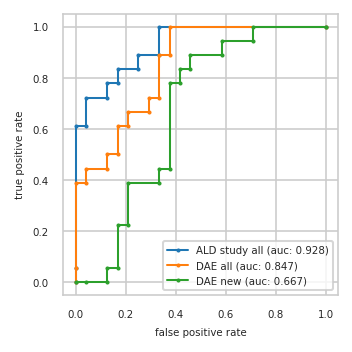

In [21]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.test, results_ald_full.name, ax)
plot_split_auc(results_model_full.test, results_model_full.name, ax)
plot_split_auc(results_model_new.test, results_model_new.name, ax)
fname = args.out_folder / 'auc_roc_curve.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Data used to plot ROC:

In [22]:
res = [results_ald_full, results_model_full, results_model_new]

auc_roc_curve = parse_roc(*res)
auc_roc_curve.to_excel(fname.with_suffix('.xlsx'))
auc_roc_curve

ALD study all       DAE all       DAE new      
             fpr   tpr     fpr   tpr     fpr   tpr
0          0.000 0.000   0.000 0.000   0.000 0.000
1          0.000 0.056   0.000 0.056   0.042 0.000
2          0.000 0.611   0.000 0.389   0.125 0.000
3          0.042 0.611   0.042 0.389   0.125 0.056
4          0.042 0.722   0.042 0.444   0.167 0.056
5          0.125 0.722   0.125 0.444   0.167 0.222
6          0.125 0.778   0.125 0.500   0.208 0.222
7          0.167 0.778   0.167 0.500   0.208 0.389
8          0.167 0.833   0.167 0.611   0.333 0.389
9          0.250 0.833   0.208 0.611   0.333 0.444
10         0.250 0.889   0.208 0.667   0.375 0.444
11         0.333 0.889   0.292 0.667   0.375 0.778
12         0.333 1.000   0.292 0.722   0.417 0.778
13         1.000 1.000   0.333 0.722   0.417 0.833
14           NaN   NaN   0.333 0.889   0.458 0.833
15           NaN   NaN   0.375 0.889   0.458 0.889
16           NaN   NaN   0.375 1.000   0.583 0.889
17           NaN   NaN   1.000 1.000   0.583 0.944
18           NaN   NaN     NaN   NaN   0.708 0.944
19           NaN   NaN     NaN   NaN   0.708 1.000
20           NaN   NaN     NaN   NaN   1.000 1.000

### Features selected for final models

In [23]:
selected_features = pd.DataFrame(
    [results_ald_full.selected_features,
     results_model_full.selected_features,
     results_model_new.selected_features],
    index=[
        results_ald_full.name,
        results_model_full.name,
        results_model_new.name]
).T
selected_features.index.name = 'rank'
fname = args.out_folder / 'mrmr_feat_by_model.xlsx'
files_out[fname.name] = fname
selected_features.to_excel(fname)
selected_features

,ALD study all,DAE all,DAE new
rank,,,
0,P04075,P10636-2;P10636-6,Q14894
1,Q9NRN5,P22676,A0A087WXB8;Q9Y274
2,P09486,P51688,F8WBF9;Q5TH30;Q9UGV2;Q9UGV2-2;Q9UGV2-3
3,K7ERG9;P00746,Q14894,P31321
4,P10636-2;P10636-6,P63104,E9PK25;G3V1A4;P23528
5,P14174,Q9Y2T3;Q9Y2T3-3,P51688
6,P61981,P04075,Q96GD0
7,Q9Y2T3;Q9Y2T3-3,P14174,O94898
8,None,P61981,Q9NUQ9


### Precision-Recall plot on test data

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/prec_recall_curve.pdf


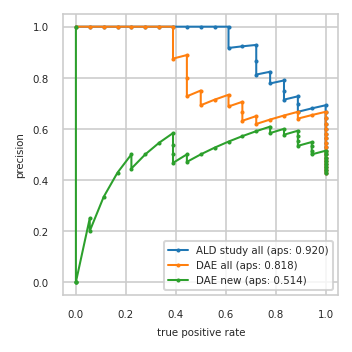

In [24]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.test, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.test, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.test, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Data used to plot PRC:

In [25]:
prec_recall_curve = parse_prc(*res)
prec_recall_curve.to_excel(fname.with_suffix('.xlsx'))
prec_recall_curve

ALD study all         DAE all         DAE new      
       precision   tpr precision   tpr precision   tpr
0          0.429 1.000     0.429 1.000     0.429 1.000
1          0.439 1.000     0.439 1.000     0.439 1.000
2          0.450 1.000     0.450 1.000     0.450 1.000
3          0.462 1.000     0.462 1.000     0.462 1.000
4          0.474 1.000     0.474 1.000     0.474 1.000
5          0.486 1.000     0.486 1.000     0.486 1.000
6          0.500 1.000     0.500 1.000     0.500 1.000
7          0.514 1.000     0.514 1.000     0.514 1.000
8          0.529 1.000     0.529 1.000     0.500 0.944
9          0.545 1.000     0.545 1.000     0.515 0.944
10         0.562 1.000     0.562 1.000     0.531 0.944
11         0.581 1.000     0.581 1.000     0.548 0.944
12         0.600 1.000     0.600 1.000     0.533 0.889
13         0.621 1.000     0.621 1.000     0.552 0.889
14         0.643 1.000     0.643 1.000     0.571 0.889
15         0.667 1.000     0.667 1.000     0.593 0.889
16         0.692 1.000     0.654 0.944     0.577 0.833
17         0.680 0.944     0.640 0.889     0.600 0.833
18         0.667 0.889     0.667 0.889     0.583 0.778
19         0.696 0.889     0.652 0.833     0.609 0.778
20         0.727 0.889     0.636 0.778     0.591 0.722
21         0.714 0.833     0.619 0.722     0.571 0.667
22         0.750 0.833     0.650 0.722     0.550 0.611
23         0.789 0.833     0.632 0.667     0.526 0.556
24         0.778 0.778     0.667 0.667     0.500 0.500
25         0.824 0.778     0.706 0.667     0.471 0.444
26         0.812 0.722     0.688 0.611     0.500 0.444
27         0.867 0.722     0.733 0.611     0.467 0.389
28         0.929 0.722     0.714 0.556     0.500 0.389
29         0.923 0.667     0.692 0.500     0.538 0.389
30         0.917 0.611     0.750 0.500     0.583 0.389
31         1.000 0.611     0.727 0.444     0.545 0.333
32         1.000 0.556     0.800 0.444     0.500 0.278
33         1.000 0.500     0.889 0.444     0.444 0.222
34         1.000 0.444     0.875 0.389     0.500 0.222
35         1.000 0.389     1.000 0.389     0.429 0.167
36         1.000 0.333     1.000 0.333     0.333 0.111
37         1.000 0.278     1.000 0.278     0.200 0.056
38         1.000 0.222     1.000 0.222     0.250 0.056
39         1.000 0.167     1.000 0.167     0.000 0.000
40         1.000 0.111     1.000 0.111     0.000 0.000
41         1.000 0.056     1.000 0.056     0.000 0.000
42         1.000 0.000     1.000 0.000     1.000 0.000

## Train data plots

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/prec_recall_curve_train.pdf


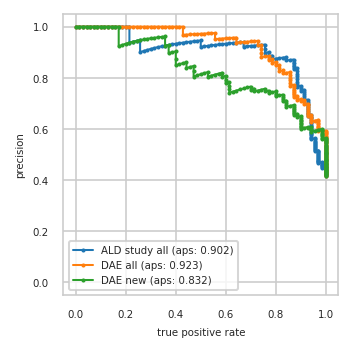

In [26]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.train, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.train, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve_train.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/auc_roc_curve_train.pdf


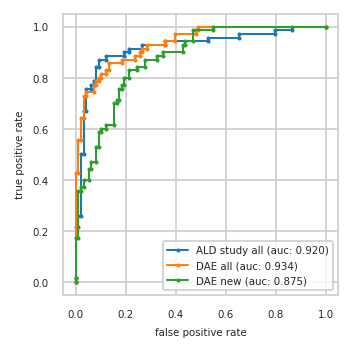

In [27]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.train, results_ald_full.name, ax)
plot_split_auc(results_model_full.train, results_model_full.name, ax)
plot_split_auc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'auc_roc_curve_train.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Output files:

In [28]:
files_out

{'results_DAE all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/results_DAE all.pkl'),
 'results_DAE new.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/results_DAE new.pkl'),
 'results_ALD study all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/results_ALD study all.pkl'),
 'auc_roc_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/auc_roc_curve.pdf'),
 'mrmr_feat_by_model.xlsx': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/mrmr_feat_by_model.xlsx'),
 'prec_recall_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/prec_recall_curve.pdf'),
 'prec_recall_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/prec_recall_curve_train.pdf'),
 'auc_roc_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/auc_roc_curve_train.pdf')}